# Predicting Argentinian Trade Balance using LSTM Model with Tensorflow/Keras

## Importing libraries and initial database cleaning

In [530]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv("trade.csv", sep=";",parse_dates=[0], date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

In [3]:
df

,Periodo,EXPORTACIONES,IMPORTACIONES,Balanza comercial en millones de US$
0,1980-01-01,626.40,712.37,-85.97
1,1980-02-01,706.42,764.54,-58.12
2,1980-03-01,726.43,805.21,-78.79
3,1980-04-01,699.57,751.17,-51.60
4,1980-05-01,637.43,774.49,-137.06
...,...,...,...,...
476,2019-09-01,5746.00,4002.00,1744.00
477,2019-10-01,5889.00,4121.00,1768.00
478,2019-11-01,5893.00,3409.00,2484.00
479,2019-12-01,5374.00,3133.00,2241.00


In [4]:
df.columns

Index(['Periodo', 'EXPORTACIONES', 'IMPORTACIONES',
       'Balanza comercial en millones de US$ '],
      dtype='object')

In [5]:
df["Periodo"]=df['Periodo'].dt.strftime( "%y-%m" )

In [6]:
df["Periodo"]=pd.to_datetime(df["Periodo"], format='%y-%m')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Periodo                                481 non-null    datetime64[ns]
 1   EXPORTACIONES                          481 non-null    float64       
 2   IMPORTACIONES                          481 non-null    float64       
 3   Balanza comercial en millones de US$   481 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 15.2 KB


In [8]:
df_updated=df.set_index("Periodo")
df_updated.head(5)

,EXPORTACIONES,IMPORTACIONES,Balanza comercial en millones de US$
Periodo,,,
1980-01-01,626.40,712.37,-85.97
1980-02-01,706.42,764.54,-58.12
1980-03-01,726.43,805.21,-78.79
1980-04-01,699.57,751.17,-51.60
1980-05-01,637.43,774.49,-137.06


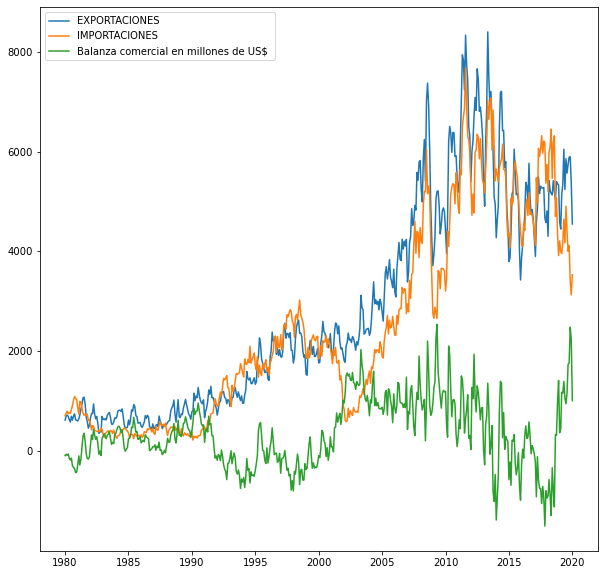

In [9]:
plt.figure(figsize=(10,10))
plt.plot(df_updated)
plt.legend(df_updated.columns)

In [531]:
trade_balance = pd.DataFrame(df_updated["Balanza comercial en millones de US$ "])

# Train with only one time series as an input 

Data is in months, and were gonna predict 80 months into the future.

## Constructing useful functions 

In [42]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)  

In [41]:
### Helper function to get y as a numpy array from the TimeseriesGenerator
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

## Scaling the data 

In [445]:
from sklearn.preprocessing import MinMaxScaler

dataset = trade_balance[1:]
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
test_size = 80
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [446]:
len(dataset)

480

## Time Series Generator

This work will take in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

In [447]:
look_back = 40

In [448]:
train_data_gen = TimeseriesGenerator(train, train,
                               length=look_back,
                               batch_size=3)

In [450]:
test_data_gen = TimeseriesGenerator(test, test,
                               length=look_back,
                               batch_size=1)

## Construction of the model 

In [451]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [452]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [454]:
history = model.fit_generator(train_data_gen,validation_data=test_data_gen, epochs=300, callbacks=[early_stop]).history

Epoch 1/300
120/120 [==============================] - 2s 16ms/step - loss: 0.0053 - val_loss: 0.0167
Epoch 2/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0164
Epoch 3/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0161
Epoch 4/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0052 - val_loss: 0.0168
Epoch 5/300
120/120 [==============================] - 2s 16ms/step - loss: 0.0052 - val_loss: 0.0166
Epoch 6/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0164
Epoch 7/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0163
Epoch 8/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0163
Epoch 9/300
120/120 [==============================] - 2s 15ms/step - loss: 0.0053 - val_loss: 0.0165
Epoch 10/300
120/120 [==============================] - 2s 15ms/step - loss: 0.005

In [455]:
model.evaluate_generator(test_data_gen)

C:\Users\Usuario\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.0154989343136549

In [456]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

C:\Users\Usuario\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(360, 1)

In [457]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(40, 1)

In [458]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [459]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)

(360, 1)
(40, 1)


In [460]:
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [461]:
dataset = scaler.inverse_transform(dataset)
dataset.shape

(480, 1)

In [527]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + trade_balance[1:]

In [528]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + trade_balance[1:]

In [464]:
predictions=testPredictPlot.dropna()
test_real_values= trade_balance.iloc[train_size:]

In [465]:
test_real_values['Predictions']=predictions

C:\Users\Usuario\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Periodo'>

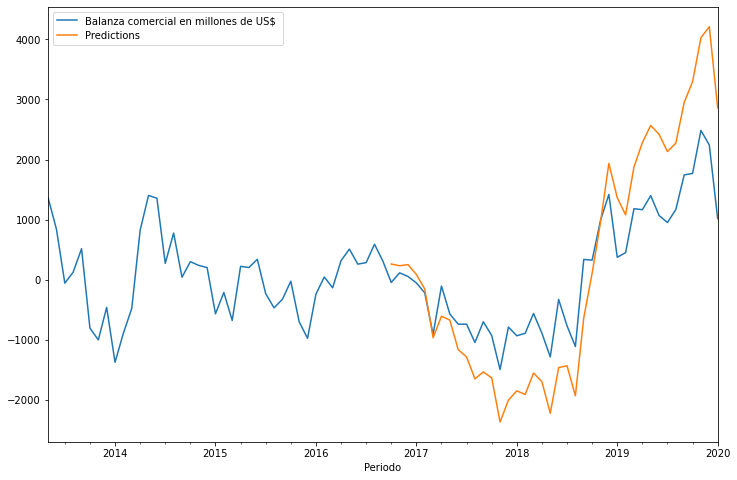

In [466]:
test_real_values.plot(figsize=(12,8))

# Retrain and Forecasting

In [482]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_full_data = scaler.fit_transform(trade_balance[1:])

In [483]:
length = 40 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [484]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [485]:
# fit model
model.fit_generator(generator,epochs=40)

C:\Users\Usuario\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
440/440 [==============================] - 9s 13ms/step - loss: 0.0607
Epoch 2/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0153
Epoch 3/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0135
Epoch 4/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0122
Epoch 5/40
440/440 [==============================] - 6s 14ms/step - loss: 0.0122
Epoch 6/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0116
Epoch 7/40
440/440 [==============================] - 6s 14ms/step - loss: 0.0110
Epoch 8/40
440/440 [==============================] - 6s 14ms/step - loss: 0.0109
Epoch 9/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0106
Epoch 10/40
440/440 [==============================] - 6s 13ms/step - loss: 0.0102
Epoch 11/40
440/440 [==============================] - 8s 19ms/step - loss: 0.0100
Epoch 12/40
440/440 [==============================] - 8s 18ms/step - loss: 0.0098
Epoch 13/40
4

In [486]:
model.save('balance_exports_LSTM_model.h')

INFO:tensorflow:Assets written to: balance_exports_LSTM_model.h\assets


INFO:tensorflow:Assets written to: balance_exports_LSTM_model.h\assets


In [515]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict_generator(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

C:\Users\Usuario\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [516]:
forecast = scaler.inverse_transform(forecast)

In [517]:
df= trade_balance[1:]

In [518]:
forecast_index = pd.date_range(start='2020-02-01',periods=periods,freq='MS')

In [519]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<AxesSubplot:>

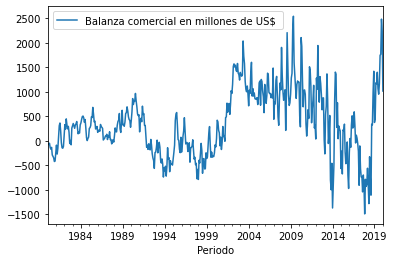

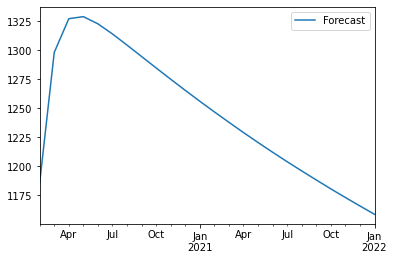

In [520]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='Periodo'>

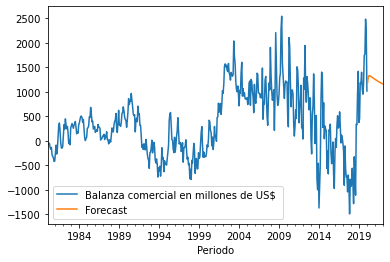

In [521]:
ax = df.plot()
forecast_df.plot(ax=ax)